In [32]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchinfo import summary
from deep_attentive_time_warping.model import BipartiteAttention
from utils import get_clf_report_dfs, plot_confusion_matrix

In [14]:
MODEL_NAME="DATW"
RESULTS_DIR=f"./results/{MODEL_NAME}/"


In [15]:
data = np.load('./dataset/dataset.npz')
X_train = data['X_train']
y_test = data['y_test']
y_mapping = data['y_mapping']

In [4]:
model = BipartiteAttention(input_ch=X_train.shape[-1])
print(model)

BipartiteAttention(
  (unet): UNet(
    (inc): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (down1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1

In [5]:
sample = X_train[0]
sample = torch.tensor(sample, dtype=torch.float32)
sample = sample.unsqueeze(0)
summary(model, input_data=[sample, sample])

Layer (type:depth-idx)                             Output Shape              Param #
BipartiteAttention                                 [1, 150, 150]             --
├─UNet: 1-1                                        [1, 1, 150, 150]          --
│    └─DoubleConv: 2-1                             [1, 64, 150, 150]         --
│    │    └─Sequential: 3-1                        [1, 64, 150, 150]         41,856
│    └─Down: 2-2                                   [1, 128, 75, 75]          --
│    │    └─Sequential: 3-2                        [1, 128, 75, 75]          221,952
│    └─Down: 2-3                                   [1, 256, 37, 37]          --
│    │    └─Sequential: 3-3                        [1, 256, 37, 37]          886,272
│    └─Down: 2-4                                   [1, 512, 18, 18]          --
│    │    └─Sequential: 3-4                        [1, 512, 18, 18]          3,542,016
│    └─Down: 2-5                                   [1, 512, 9, 9]            --
│    │    └─Se

In [6]:
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_pretraining_history.pkl"), 'rb') as f:
    pretraining_history = pickle.load(f)
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_contrastive_history.pkl"), 'rb') as f:
    contrastive_history = pickle.load(f)
y_pred = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_predictions.npy"))

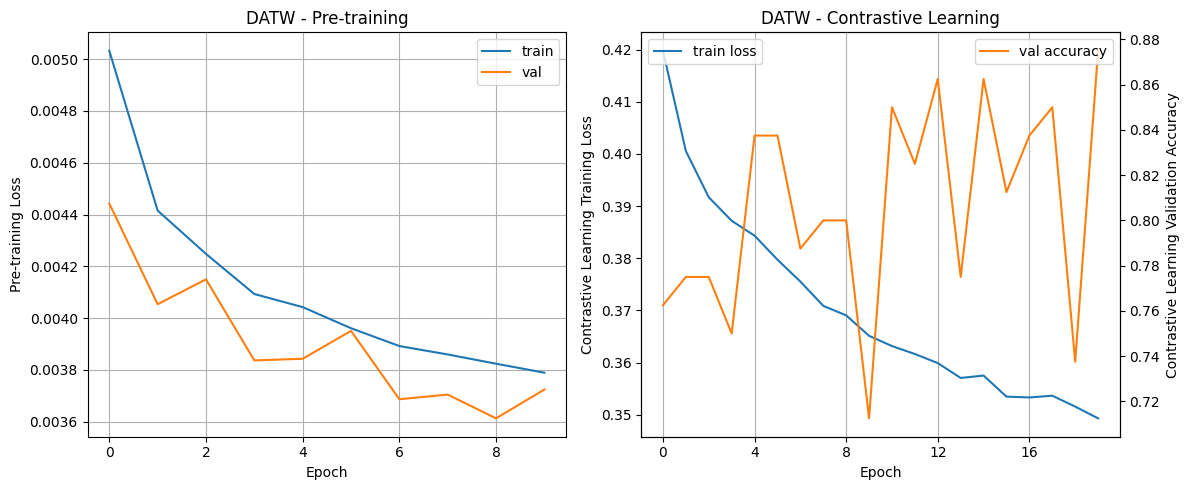

In [7]:
# TODO: concatena

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(pretraining_history["train_loss"], label="train")
ax1.plot(pretraining_history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Pre-training")
ax1.set_ylabel("Pre-training Loss")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(contrastive_history["train_loss"], label="train loss")
ax2.set_title(f"{MODEL_NAME} - Contrastive Learning")
ax2.set_ylabel("Contrastive Learning Training Loss")
ax2.set_xlabel("Epoch")
ax2.legend(loc="upper left")
ax2.set_xticks(range(0, 21, 2))
ax2.grid(True, axis='x')

ax2_twin = ax2.twinx()
ax2_twin.plot(contrastive_history["val_acc"], label="val accuracy", color='tab:orange')
ax2_twin.set_ylabel("Contrastive Learning Validation Accuracy")
ax2_twin.legend(loc="upper right")

fig.tight_layout()

In [8]:
y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_per_class_clf_scores.csv")
)

# TODO: concatena

clf_scores_df

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.814815,0.813844,0.816143,0.838235,0.843621,0.817647,0.814815


In [9]:
# TODO: solo per migliore
per_class_clf_scores_df.style.background_gradient(cmap="Blues")

,precision,recall,f1-score,support
ball,1.000000,0.500000,0.666667,4.000000
bigball,1.000000,1.000000,1.000000,5.000000
box,0.666667,1.000000,0.800000,4.000000
button,1.000000,0.833333,0.909091,6.000000
case,1.000000,0.800000,0.888889,5.000000
cube,0.750000,0.750000,0.750000,4.000000
cylinder,0.666667,0.800000,0.727273,5.000000
empty,1.000000,1.000000,1.000000,5.000000
jenga,0.500000,0.750000,0.600000,4.000000
labello,1.000000,0.600000,0.750000,5.000000


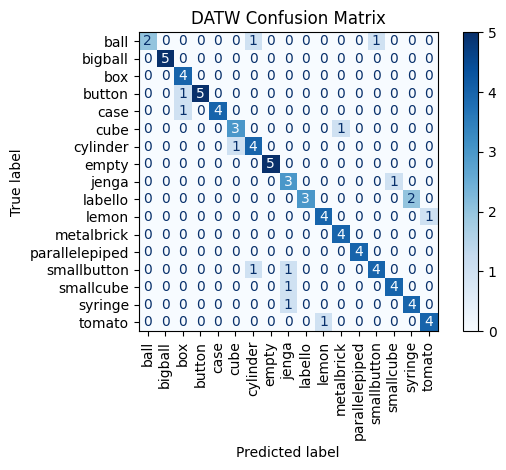

In [10]:
# TODO: solo per migliore
plot_confusion_matrix(
    y_true=y_test_str,
    y_pred=y_pred_str,
    title=f"{MODEL_NAME} Confusion Matrix",
    path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_confusion_matrix.png")
)

In [17]:
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_smaller_tau", f"{MODEL_NAME}_pretraining_history.pkl"), 'rb') as f:
    pretraining_history = pickle.load(f)
with open(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_smaller_tau", f"{MODEL_NAME}_contrastive_history.pkl"), 'rb') as f:
    contrastive_history = pickle.load(f)
y_pred = np.load(os.path.join(RESULTS_DIR, f"{MODEL_NAME}_smaller_tau", f"{MODEL_NAME}_predictions.npy"))

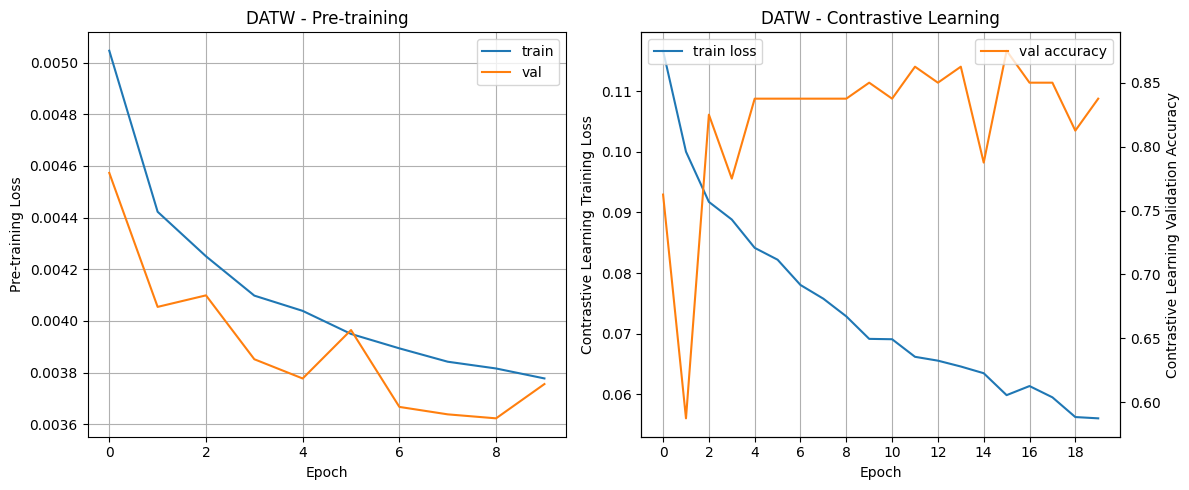

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(pretraining_history["train_loss"], label="train")
ax1.plot(pretraining_history["val_loss"], label="val")
ax1.set_title(f"{MODEL_NAME} - Pre-training")
ax1.set_ylabel("Pre-training Loss")
ax1.set_xlabel("Epoch")
ax1.grid()
ax1.legend()

ax2.plot(contrastive_history["train_loss"], label="train loss")
ax2.set_title(f"{MODEL_NAME} - Contrastive Learning")
ax2.set_ylabel("Contrastive Learning Training Loss")
ax2.set_xlabel("Epoch")
ax2.legend(loc="upper left")
ax2.set_xticks(range(0, 21, 2))
ax2.grid(True, axis='x')

ax2_twin = ax2.twinx()
ax2_twin.plot(contrastive_history["val_acc"], label="val accuracy", color='tab:orange')
ax2_twin.set_ylabel("Contrastive Learning Validation Accuracy")
ax2_twin.legend(loc="upper right")

fig.tight_layout()

In [19]:
y_test_str = [y_mapping[label] for label in y_test]
y_pred_str = [y_mapping[label] for label in y_pred]

clf_scores_df, per_class_clf_scores_df = get_clf_report_dfs(
    y_true=y_test_str, y_pred=y_pred_str,
    clf_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_clf_scores.csv"),
    clf_per_class_scores_path=os.path.join(RESULTS_DIR, f"{MODEL_NAME}_default", f"{MODEL_NAME}_per_class_clf_scores.csv")
)

# TODO: concatena

clf_scores_df

,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
0,0.82716,0.828372,0.820239,0.845938,0.846767,0.839216,0.82716


In [11]:
# TODO:
# contrastive learning: 
# pre-training: 64 * 100 = 6400 sample pairs
# training: 64 * 500 = 32000 sample pairs
# total number of sample pairs: (tr_size)^2=
# 32000/(tr_size**)*100 = 
# KNN, 3 (uniform)
# tau is hinge loss margin
# incrementa il numero di epoche?


# rapporto
# tau che cambia?
# modello più piccolo?

## 5-shot setting

Reading predictions and computing classification metrics:

In [39]:
_5_shot_dir = f"./results/{MODEL_NAME}/{MODEL_NAME}_5shot"

y_pred_query_full_5 = np.load(os.path.join(_5_shot_dir, f"{MODEL_NAME}_predictions_few_shot_full_ref.npy"))
y_pred_query_sub_5 = np.load(os.path.join(_5_shot_dir, f"{MODEL_NAME}_predictions_few_shot_sub_ref.npy"))
y_pred_query_new_5 = np.load(os.path.join(_5_shot_dir, f"{MODEL_NAME}_predictions_few_shot_new_ref.npy"))

_5_shot_data = np.load('./dataset/5shot_dataset.npz')
y_support_5 = _5_shot_data['y_support']
y_query_5 = _5_shot_data['y_query']

base_data = np.load('./dataset/base_dataset.npz')
y_base_test = base_data['y_test']

y_base_test_str = [y_mapping[label] for label in y_base_test]
y_support_5_str = [y_mapping[label] for label in y_support_5]
y_query_5_str = [y_mapping[label] for label in y_query_5]

base_test_labels = np.unique(y_base_test_str)
_5_support_labels = np.unique(y_support_5_str)
labels_5 = np.concatenate((base_test_labels, _5_support_labels))

y_pred_query_full_5_str = [y_mapping[label] for label in y_pred_query_full_5]
y_pred_query_sub_5_str = [y_mapping[label] for label in y_pred_query_sub_5]
y_pred_query_new_5_str = [y_mapping[label] for label in y_pred_query_new_5]

clf_scores_5s_df = pd.DataFrame()
clf_scores_5s_full_df, per_class_clf_scores_5s_full_df = get_clf_report_dfs(
    y_true=y_query_5_str, y_pred=y_pred_query_full_5_str
)
clf_scores_5s_sub_df, per_class_clf_scores_5s_sub_df = get_clf_report_dfs(
    y_true=y_query_5_str, y_pred=y_pred_query_sub_5_str
)
clf_scores_5s_new_df, per_class_clf_scores_5s_new_df = get_clf_report_dfs(
    y_true=y_query_5_str, y_pred=y_pred_query_new_5_str
)
clf_scores_5s_df = pd.concat([clf_scores_5s_full_df, clf_scores_5s_sub_df, clf_scores_5s_new_df], axis=0)
clf_scores_5s_df.index = ['Full Ref', 'Sub Ref', 'New Ref']

/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [40]:
print("Aggregated scores for new classes using different reference sets:")
display(clf_scores_5s_df.style.background_gradient(cmap="Blues"))
clf_scores_5s_df.to_csv(os.path.join(_5_shot_dir, f"{MODEL_NAME}_clf_scores.csv"))

Aggregated scores for new classes using different reference sets:


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
Full Ref,0.261905,0.115253,0.361846,0.275408,0.885145,0.084224,0.261905
Sub Ref,0.552381,0.221240,0.670770,0.303783,0.914065,0.181341,0.552381
New Ref,0.861905,0.863981,0.863310,0.869240,0.871661,0.865531,0.861905


In [41]:
print("Per class scores for new classes using all training data and the support set as reference set:")
display(per_class_clf_scores_5s_full_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:")
display(per_class_clf_scores_5s_sub_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using only the support set as reference set:")
display(per_class_clf_scores_5s_new_df[-5:].style.background_gradient(cmap="Blues"))


Per class scores for new classes using all training data and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.950000,0.542857,0.690909,35.000000
smallbutton,1.000000,0.244898,0.393443,49.000000
smallcube,1.000000,0.023810,0.046512,42.000000
syringe,0.956522,0.511628,0.666667,43.000000
tomato,0.500000,0.024390,0.046512,41.000000


Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.913043,0.600000,0.724138,35.000000
smallbutton,1.000000,0.795918,0.886364,49.000000
smallcube,0.863636,0.452381,0.593750,42.000000
syringe,0.870968,0.627907,0.729730,43.000000
tomato,0.909091,0.243902,0.384615,41.000000


Per class scores for new classes using only the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.846154,0.942857,0.891892,35.000000
smallbutton,0.953488,0.836735,0.891304,49.000000
smallcube,0.842105,0.761905,0.800000,42.000000
syringe,0.730769,0.883721,0.800000,43.000000
tomato,0.973684,0.902439,0.936709,41.000000


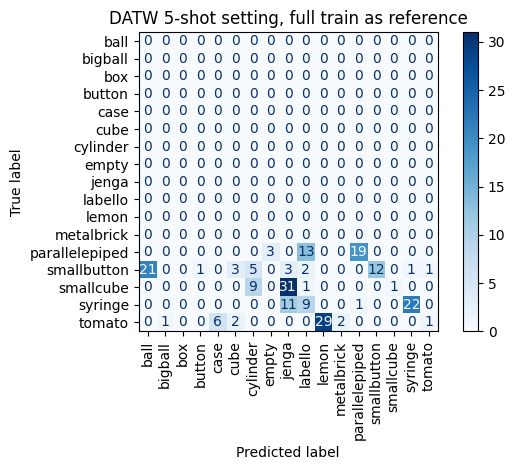

In [42]:
plot_confusion_matrix(
    y_true=y_query_5_str,
    y_pred=y_pred_query_full_5_str,
    title=f"{MODEL_NAME} 5-shot setting, full train as reference",
    path=os.path.join(_5_shot_dir, f"{MODEL_NAME}_confusion_matrix_full_ref.png"),
    labels=labels_5,
)

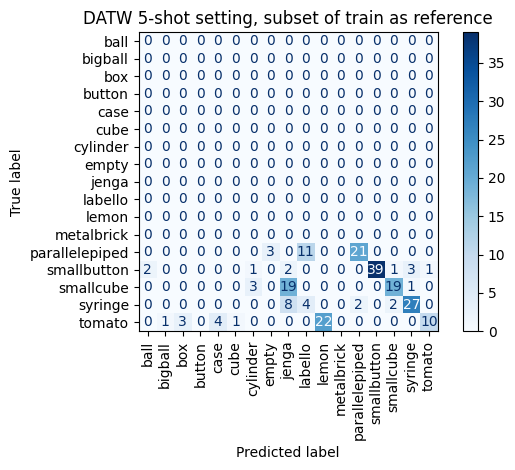

In [43]:
plot_confusion_matrix(
    y_true=y_query_5_str,
    y_pred=y_pred_query_sub_5_str,
    title=f"{MODEL_NAME} 5-shot setting, subset of train as reference",
    path=os.path.join(_5_shot_dir, f"{MODEL_NAME}_confusion_matrix_sub_ref.png"),
    labels=labels_5,
)

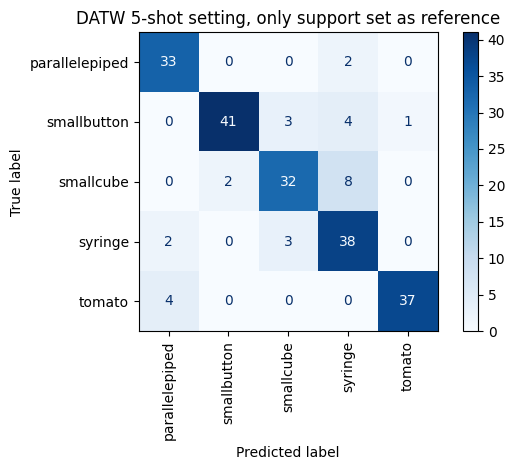

In [44]:
plot_confusion_matrix(
    y_true=y_query_5_str,
    y_pred=y_pred_query_new_5_str,
    title=f"{MODEL_NAME} 5-shot setting, only support set as reference",
    path=os.path.join(_5_shot_dir, f"{MODEL_NAME}_confusion_matrix_new_ref.png")
)

## 10-shot setting

Reading predictions and computing classification metrics:

In [45]:
_10_shot_dir = f"./results/{MODEL_NAME}/{MODEL_NAME}_10shot"

y_pred_query_full_10 = np.load(os.path.join(_10_shot_dir, f"{MODEL_NAME}_predictions_few_shot_full_ref.npy"))
y_pred_query_sub_10 = np.load(os.path.join(_10_shot_dir, f"{MODEL_NAME}_predictions_few_shot_sub_ref.npy"))
y_pred_query_new_10 = np.load(os.path.join(_10_shot_dir, f"{MODEL_NAME}_predictions_few_shot_new_ref.npy"))

_10_shot_data = np.load('./dataset/10shot_dataset.npz')
y_support_10 = _10_shot_data['y_support']
y_query_10 = _10_shot_data['y_query']

y_support_10_str = [y_mapping[label] for label in y_support_10]
y_query_10_str = [y_mapping[label] for label in y_query_10]

_10_support_labels = np.unique(y_support_10_str)
labels_10 = np.concatenate((base_test_labels, _10_support_labels))

y_pred_query_full_10_str = [y_mapping[label] for label in y_pred_query_full_10]
y_pred_query_sub_10_str = [y_mapping[label] for label in y_pred_query_sub_10]
y_pred_query_new_10_str = [y_mapping[label] for label in y_pred_query_new_10]

clf_scores_10s_df = pd.DataFrame()
clf_scores_10s_full_df, per_class_clf_scores_10s_full_df = get_clf_report_dfs(
    y_true=y_query_10_str, y_pred=y_pred_query_full_10_str
)
clf_scores_10s_sub_df, per_class_clf_scores_10s_sub_df = get_clf_report_dfs(
    y_true=y_query_10_str, y_pred=y_pred_query_sub_10_str
)
clf_scores_10s_new_df, per_class_clf_scores_10s_new_df = get_clf_report_dfs(
    y_true=y_query_10_str, y_pred=y_pred_query_new_10_str
)
clf_scores_10s_df = pd.concat([clf_scores_10s_full_df, clf_scores_10s_sub_df, clf_scores_10s_new_df], axis=0)
clf_scores_10s_df.index = ['Full Ref', 'Sub Ref', 'New Ref']

/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/irenetesta/anaconda3/envs/robotics/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

In [46]:
print("Aggregated scores for new classes using different reference sets:")
display(clf_scores_10s_df.style.background_gradient(cmap="Blues"))
clf_scores_10s_df.to_csv(os.path.join(_10_shot_dir, f"{MODEL_NAME}_clf_scores.csv"))

Aggregated scores for new classes using different reference sets:


,accuracy,f1-score macro avg,f1-score weighted avg,precision macro avg,precision weighted avg,recall macro avg,recall weighted avg
Full Ref,0.464865,0.189817,0.586929,0.299038,0.957131,0.153196,0.464865
Sub Ref,0.664865,0.299011,0.765835,0.361445,0.939097,0.262507,0.664865
New Ref,0.881081,0.884006,0.880193,0.886104,0.886736,0.888947,0.881081


In [47]:
print("Per class scores for new classes using all training data and the support set as reference set:")
display(per_class_clf_scores_10s_full_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:")
display(per_class_clf_scores_10s_sub_df[-5:].style.background_gradient(cmap="Blues"))
print("Per class scores for new classes using only the support set as reference set:")
display(per_class_clf_scores_10s_new_df[-5:].style.background_gradient(cmap="Blues"))


Per class scores for new classes using all training data and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,1.000000,0.966667,0.983051,30.000000
smallbutton,1.000000,0.250000,0.400000,44.000000
smallcube,0.900000,0.243243,0.382979,37.000000
syringe,0.961538,0.657895,0.781250,38.000000
tomato,0.923077,0.333333,0.489796,36.000000


Per class scores for new classes using a subset of the training data (proportional to the support set) and the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.967742,1.000000,0.983607,30.000000
smallbutton,0.956522,0.500000,0.656716,44.000000
smallcube,0.913043,0.567568,0.700000,37.000000
syringe,0.909091,0.789474,0.845070,38.000000
tomato,0.952381,0.555556,0.701754,36.000000


Per class scores for new classes using only the support set as reference set:


,precision,recall,f1-score,support
parallelepiped,0.909091,1.000000,0.952381,30.000000
smallbutton,0.945946,0.795455,0.864198,44.000000
smallcube,0.878788,0.783784,0.828571,37.000000
syringe,0.777778,0.921053,0.843373,38.000000
tomato,0.918919,0.944444,0.931507,36.000000


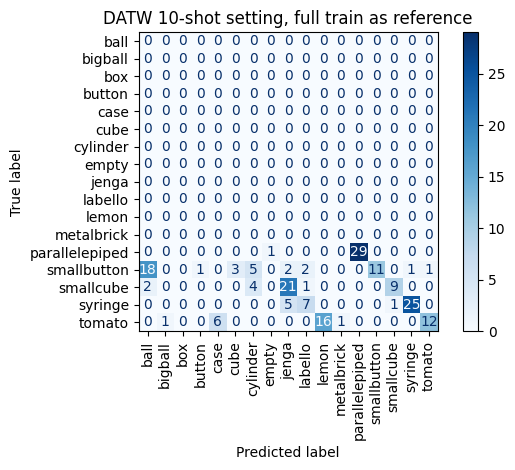

In [48]:
plot_confusion_matrix(
    y_true=y_query_10_str,
    y_pred=y_pred_query_full_10_str,
    title=f"{MODEL_NAME} 10-shot setting, full train as reference",
    path=os.path.join(_10_shot_dir, f"{MODEL_NAME}_confusion_matrix_full_ref.png"),
    labels=labels_10,
)

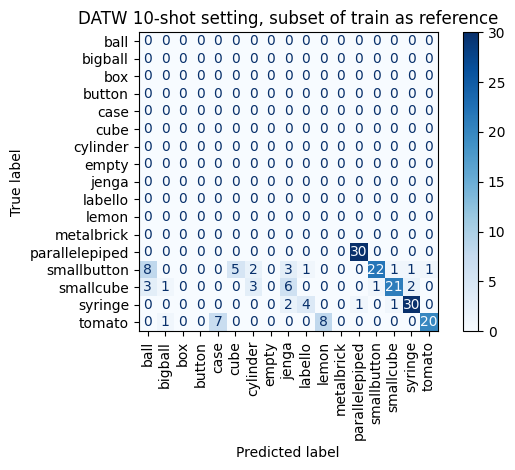

In [49]:
plot_confusion_matrix(
    y_true=y_query_10_str,
    y_pred=y_pred_query_sub_10_str,
    title=f"{MODEL_NAME} 10-shot setting, subset of train as reference",
    path=os.path.join(_10_shot_dir, f"{MODEL_NAME}_confusion_matrix_sub_ref.png"),
    labels=labels_10,
)

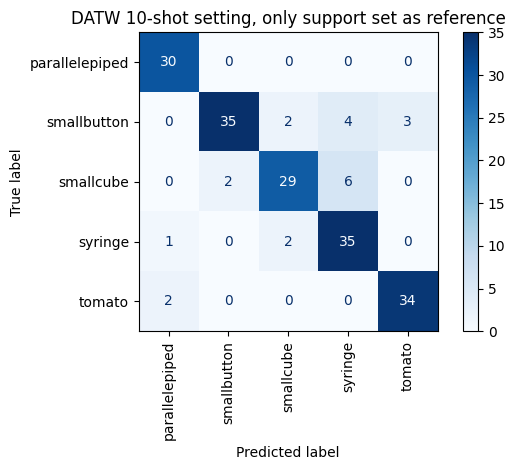

In [50]:
plot_confusion_matrix(
    y_true=y_query_10_str,
    y_pred=y_pred_query_new_10_str,
    title=f"{MODEL_NAME} 10-shot setting, only support set as reference",
    path=os.path.join(_10_shot_dir, f"{MODEL_NAME}_confusion_matrix_new_ref.png")
)